In [1]:
import netCDF4
from distutils.util import strtobool
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import pdb
import platform
import numpy as np
import pyproj as pyproj
import datetime
import time
import bmi.wrapper
import pcrglobwb_bmi_v203 as pcrglobwb_bmi_v203
from pcrglobwb_bmi_v203 import pcrglobwb_bmi
from pcrglobwb_bmi_v203 import disclaimer
# from coupling_PCR_FM import coupling_functions
# from coupling_PCR_FM import model_functions
from coupling_PCR_FM import configuration
from coupling_PCR_FM import utils as utils

In [2]:
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model

In [3]:
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE
# -------------------------------------------------------------------------------------------------

# parse set/ini-file with central/general settings for coupling framework
config = configuration.Configuration()
config.parse_configuration_file(argv1)

# parse env-file for user-specific paths and environmental variables
envs = configuration.Configuration()
envs.parse_configuration_file(argv2)

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

type_hydrodynamicModel = config.hydrodynamic_model['model_name']
type_routingModel          = config.routing_model['model_name']
type_hydrologicModel      = config.hydrologic_model['model_name']

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.hydrodynamic_model['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])
use_RFS = strtobool(config.general_settings['use_RFS'])
verbose = strtobool(config.general_settings['verbose'])

In [5]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

startTime_env						= config.numerical_settings['startTime']
endTime_env							= config.numerical_settings['endTime']
nr_timesteps 						  = utils.determineSteps(startTime_env, endTime_env)
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [6]:
# -------------------------------------------------------------------------------------------------
# GET ENVIRONMENT SETTINGS
# -------------------------------------------------------------------------------------------------
mainFolder = os.getcwd()
inputDIR_env 	= envs.PCRpaths['inputDirectoryPCR']
outputDIR_env 	= envs.PCRpaths['outputDirectoryPCR']
DFM_path		= envs.DFM_engine['DFM_path'] #absolute
CMF_path		= os.path.join(mainFolder, envs.CMF_engine['CMF_path']) #relative

In [7]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# get main folder (i.e. GitHub folder)


# hydrodynamic model
hydrodynamicModel_dir       	= config.hydrodynamic_model['model_dir']
hydrodynamicModel_dir           = os.path.join(mainFolder, hydrodynamicModel_dir)
hydrodynamicModel_file      	= config.hydrodynamic_model['model_file']
hydrodynamicModel_proj		    = config.hydrodynamic_model['model_projection']

### ROUTING MODEL ###
routingModel_dir       			= config.routing_model['model_dir']
routingModel_dir           		= os.path.join(mainFolder, routingModel_dir)
routingModel_file      			= config.routing_model['model_file']
routingModel_file_tmp			= str('tmp_'+routingModel_file )
routingModel_config	   			= os.path.join(mainFolder, os.path.join(routingModel_dir, routingModel_file))
routingModel_config_tmp 		= os.path.join(mainFolder, os.path.join(routingModel_dir, routingModel_file_tmp))

# hydrologic model
hydrologicModel_dir				= config.hydrologic_model['config_dir']
hydrologicModel_file       		= config.hydrologic_model['config_file']
hydrologicModel_file_tmp		= str('tmp_'+hydrologicModel_file)
hydrologicModel_config	        = os.path.join(mainFolder, os.path.join(hydrologicModel_dir, hydrologicModel_file))
hydrologicModel_config_tmp 		= os.path.join(mainFolder, os.path.join(hydrologicModel_dir, hydrologicModel_file_tmp))

# overwriting inputDIR and outputDIR in PCR-GLOBWB ini-file with respect to personal environment
kwargs = dict(inputDir = inputDIR_env, outputDir = outputDIR_env)
utils.write_ini(hydrologicModel_config_tmp, hydrologicModel_config, **kwargs)

# parsing the overwritten PCR-GLOBWB ini-file
configPCR 						= configuration.Configuration()
configPCR.parse_configuration_file(hydrologicModel_config_tmp)

# retrieving informatino directly from PCR-GLOBWB ini-file
inputDIR 						= configPCR.globalOptions['inputDir']
clone_pcr 						= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 					= os.path.join(inputDIR, configPCR.globalOptions['landmask'])

# initialize new

In [8]:
# overwriting inputDIR and outputDIR in PCR-GLOBWB ini-file with respect to personal environment
kwargs = dict(inputDir = inputDIR_env, outputDir = outputDIR_env, startTime = startTime_env, endTime = endTime_env)
utils.write_ini(hydrologicModel_config_tmp, hydrologicModel_config, **kwargs)

hydrologicModel = PCR_model(hydrologicModel_config_tmp, missing_value_pcr)
# hydrologicModel.spinup()

2018-01-24 22:12:24,983 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-01-24 22:12:24.963134
2018-01-24 22:12:24,986 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/dirk/experiments/glofrim/output30min/log/tmp_setup_PCR_30min_Elbe.ini_2018-01-24T22:12:24.963134.log
2018-01-24 22:12:24,988 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-01-24 22:12:24,990 pcrglobwb_bmi_v203.configuration INFO The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. Note that the "subDischargeIni" is only relevant if kinematic wave approaches are used.
2018-01-24 22:12:24,991 pcrglobwb_bmi_v203.currTimeStep INFO number of time steps :10
2018-01-24 22:12:25,173 pcrglobwb_bmi_v203.meteo INFO No forcing downscaling is implemented.
2018-01-24 22:12:30,177 pcrglobwb_bmi_v203.deterministic_runner INFO Adjusting some model parameters based on give

In [9]:
# overwriting nam-file
# kwargs = dict(CINPMAT = 'bla')
# utils.write_ini(routingModel_config_tmp, routingModel_config, **kwargs)

routingModel = CMF_model(CMF_path, os.path.join(routingModel_dir, routingModel_file), routingModel_dir)

2018-01-24 22:12:30,191 bmi.wrapper INFO Loading library from path /home/dirk/repos/glofrim_vu/cama-flood_bmi/src/libcama.so
2018-01-24 22:12:30,203 bmi.wrapper INFO Loading model /home/dirk/repos/glofrim_vu/test_Elbe/CMF_Elbe/ in directory /home/dirk/repos/glofrim_vu/test_Elbe/CMF_Elbe


2018-01-24 22:12:30,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
2018-01-24 22:12:30,403 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
2018-01-24 22:12:31,373 coupling_PCR_FM.model_functions_v2 INFO start_time: 2000-01-01, current_time 2000-01-01, timestep 1


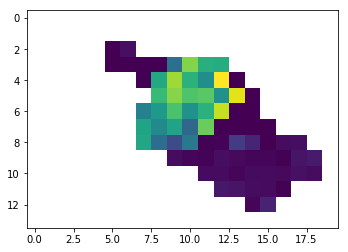

In [ ]:
hydrologicModel.update(1)
runoff = hydrologicModel.get_var('landSurfaceRunoff')

%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(runoff)

In [ ]:
routingModel.update(runoff, 1)
outflw = routingModel.get_var('outflw')
plt.imshow(outflw)